In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential

import pathlib

import os

2023-02-11 17:01:10.665978: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-11 17:01:10.780409: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-11 17:01:10.780432: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-11 17:01:11.530091: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

*/*.JPG, */*.jpg and */*.* all return different values, meaning the dataset has different file types

In [2]:
data_dir = pathlib.Path('plantvillage')

folders = os.listdir(data_dir)

image_count = len(list(data_dir.glob('*/*.*')))
print(image_count)


18835


In [3]:
bacterial_spot = list(data_dir.glob('Tomato___Bacterial_spot/*'))
early_blight = list(data_dir.glob('Tomato___Early_blight/*'))
healthy = list(data_dir.glob('Tomato___healthy/*'))
late_blight = list(data_dir.glob('Tomato___Late_blight/*'))
leaf_mold = list(data_dir.glob('Tomato___Leaf_Mold/*'))
septoria_leaf_spot = list(data_dir.glob('Tomato___Septoria_leaf_spot/*'))
spider_mites = list(data_dir.glob('Tomato___Spider_mites Two-spotted_spider_mite/*'))
target_spot = list(data_dir.glob('Tomato___Target_Spot/*'))
mosaic = list(data_dir.glob('Tomato___Tomato_mosaic_virus/*'))
yellow_leaf_curl = list(data_dir.glob('Tomato___Tomato_Yellow_Leaf_Curl_Virus/*'))

for img in yellow_leaf_curl:
    arr = np.array(PIL.Image.open(img))
    if not (arr.shape == (256, 256, 3)):
        raise Exception

# for subdir in list(data_dir.glob('*')):
#     print(subdir)
#     print(len(list(subdir.glob('*'))))
#     imgs = list(subdir.glob('*'))
#     PIL.Image.open(str(imgs[0]))

In [4]:
batch_size = 64
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18835 files belonging to 10 classes.
Using 15068 files for training.


2023-02-11 17:01:20.474321: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-11 17:01:20.474385: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-11 17:01:20.474416: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vedkm-foliagefixermode-l8v7u6tacyt): /proc/driver/nvidia/version does not exist
2023-02-11 17:01:20.474729: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 18835 files belonging to 10 classes.
Using 3767 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


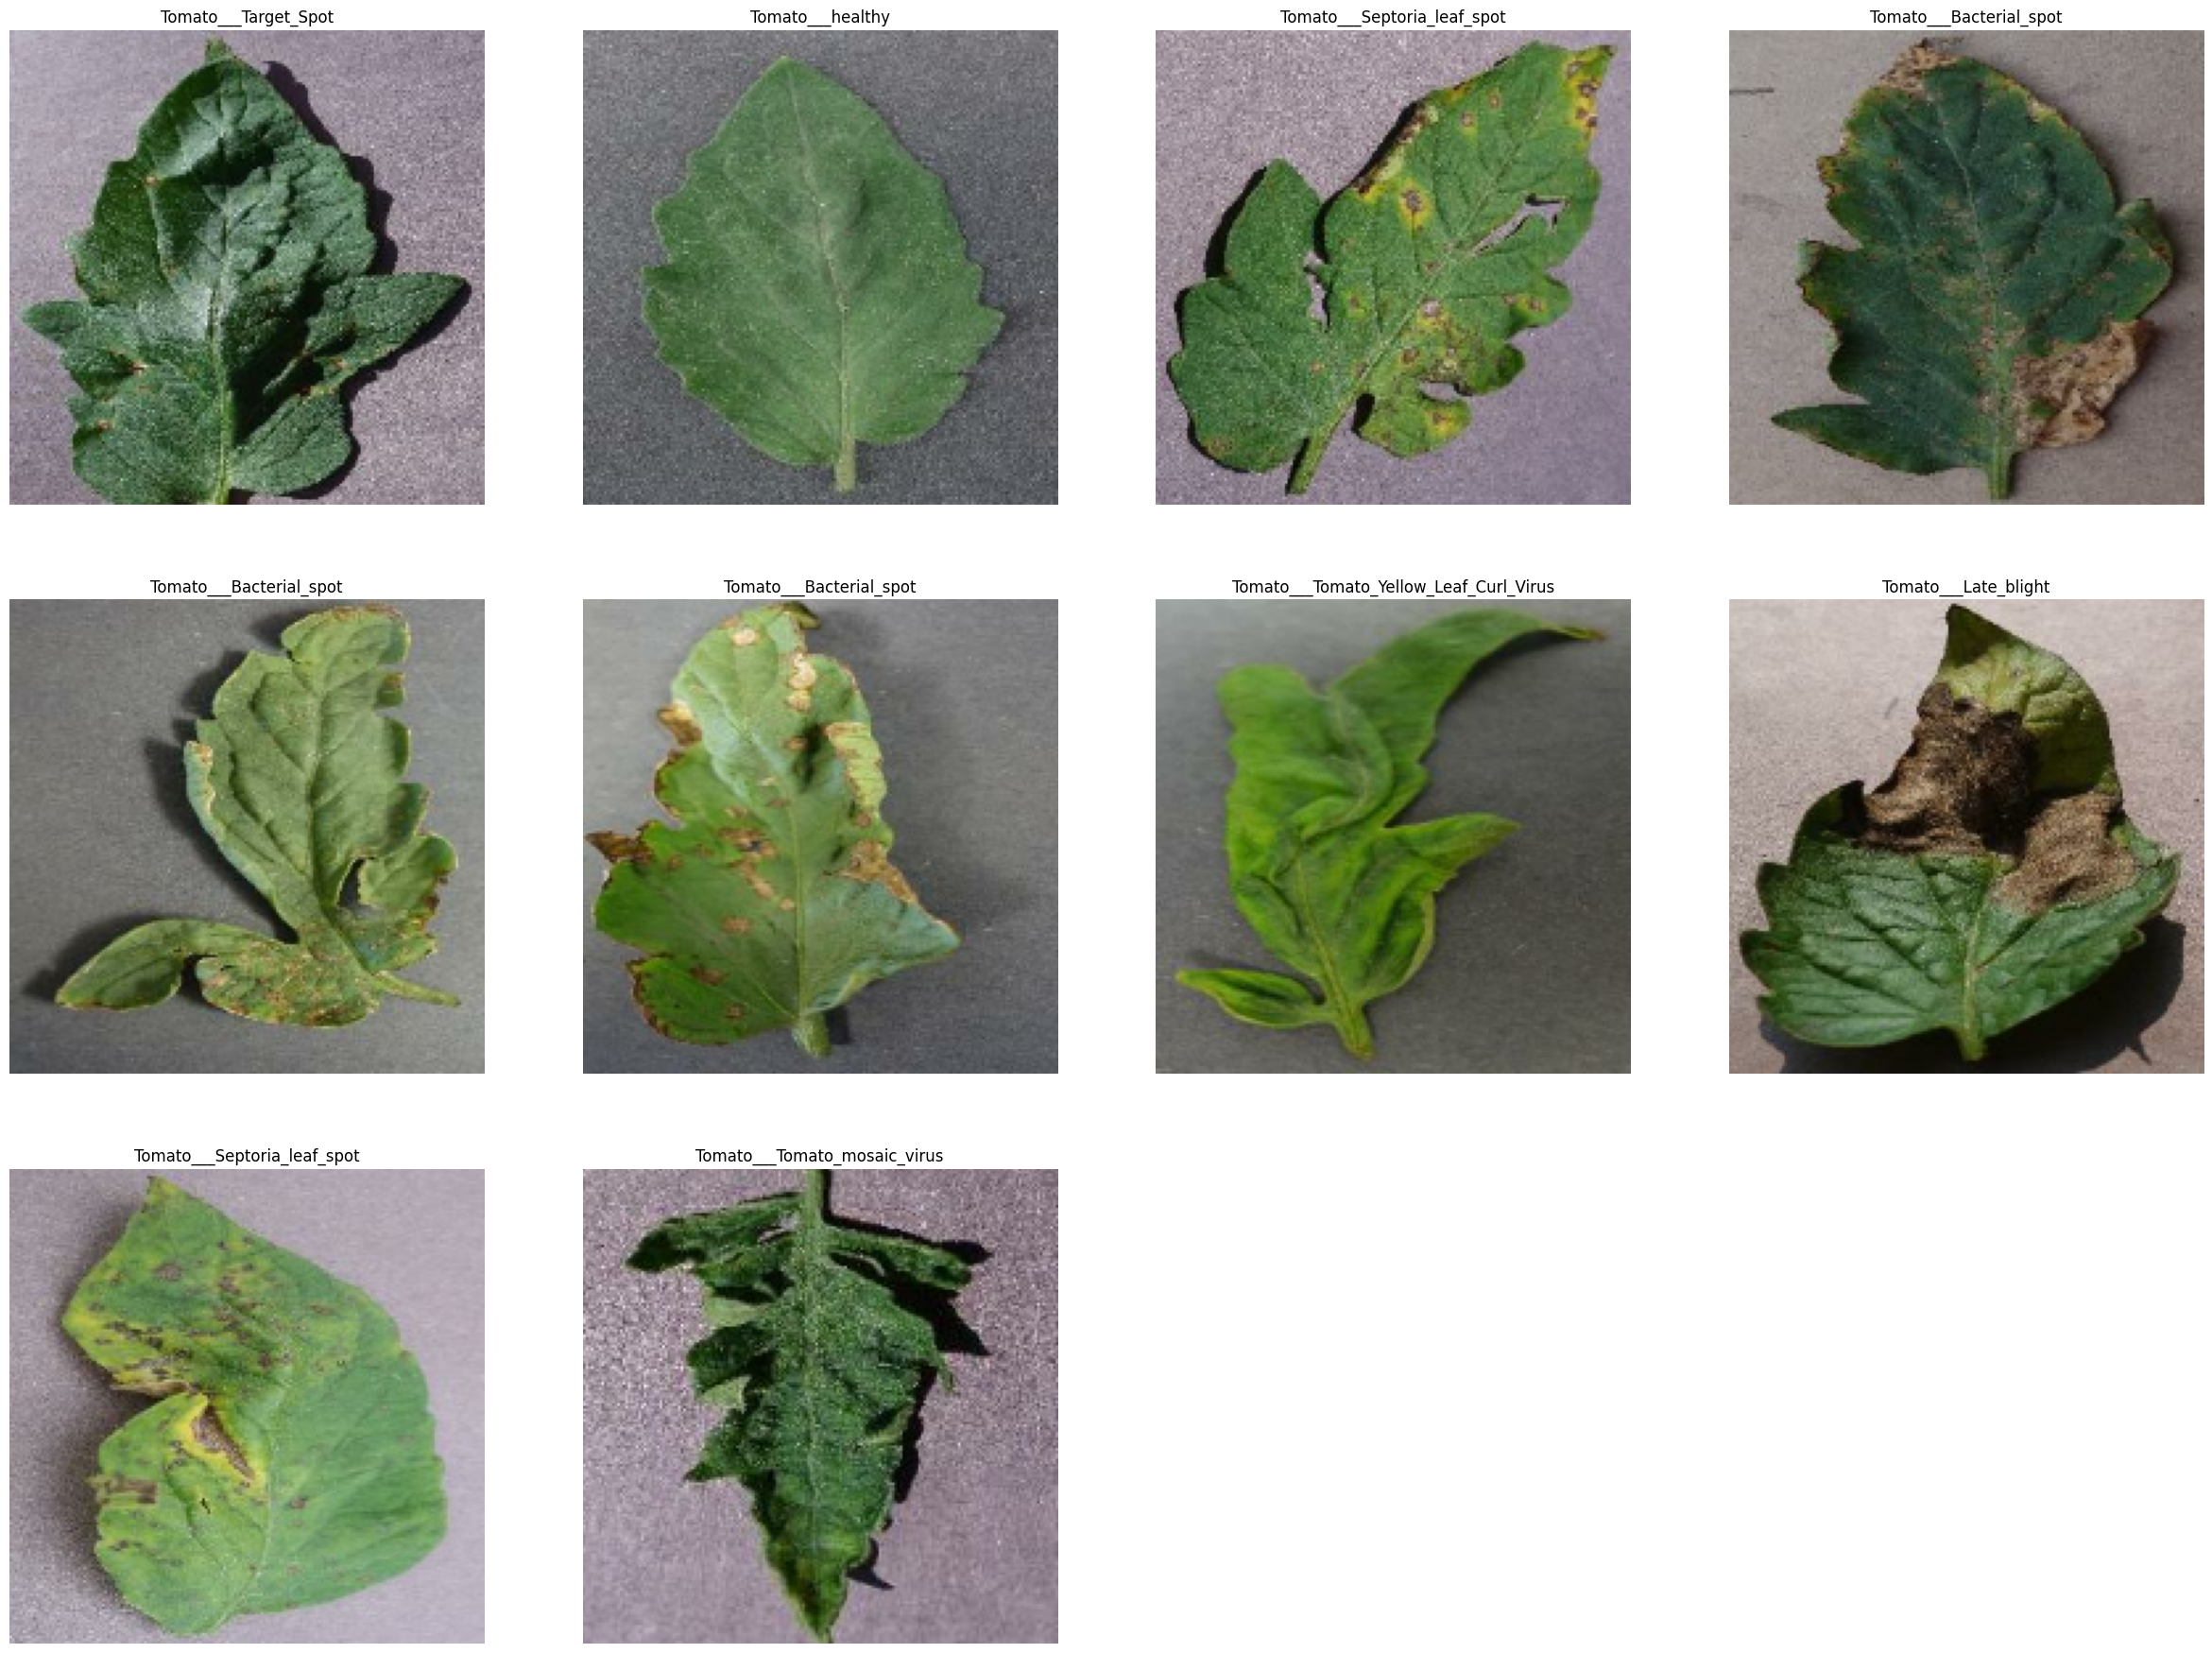

In [6]:
plt.figure(figsize=(30, 30))
for images, labels in train_ds.take(1):
  for i in range(10):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 180, 180, 3)
(64,)


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
normalization_layer = layers.Rescaling(scale=1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.0 0.8466275


In [10]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomCrop(img_height, img_width),
    layers.RandomTranslation(height_factor=(-0.2, 0.3), width_factor=(-0.2, 0.3))
  ]
)

2023-02-11 17:01:35.517771: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: loop_body/cond/pfor/cond/branch_executed/_191


2023-02-11 17:01:38.297990: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: loop_body/cond/pfor/cond/branch_executed/_191


2023-02-11 17:01:41.068503: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: loop_body/cond/branch_executed/_9


2023-02-11 17:01:43.879976: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: loop_body/cond/pfor/cond/branch_executed/_191


2023-02-11 17:01:46.930939: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: loop_body/cond/pfor/cond/branch_executed/_191


2023-02-11 17:01:49.744601: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: loop_body/cond/pfor/cond/branch_executed/_191


2023-02-11 17:01:52.560335: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: loop_body/cond/pfor/cond/branch_executed/_191


2023-02-11 17:01:55.375925: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: loop_body/cond/pfor/cond/branch_executed/_191


2023-02-11 17:01:58.335966: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: loop_body/cond/pfor/cond/branch_executed/_191


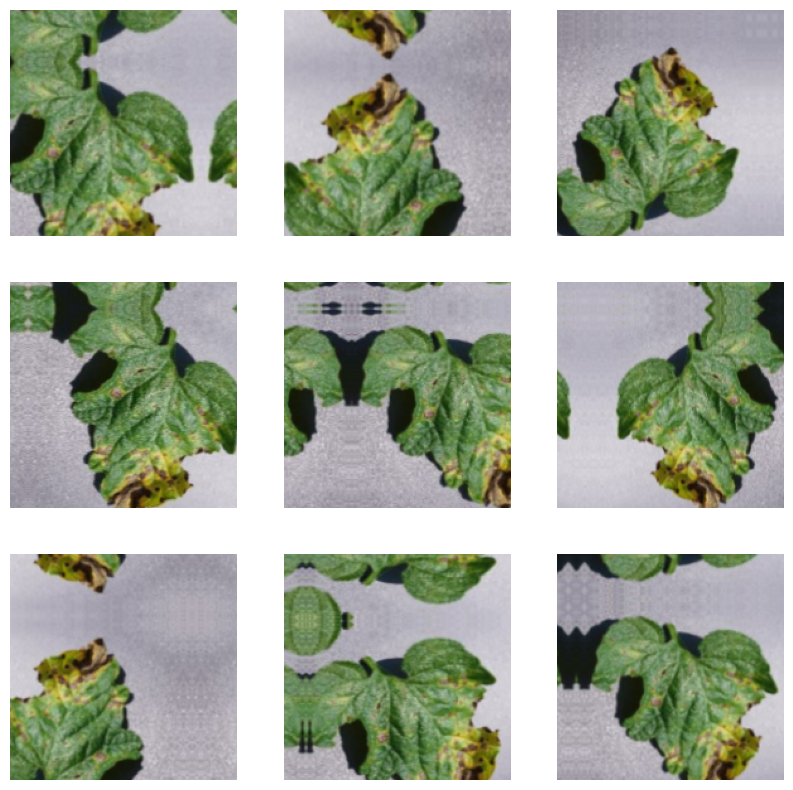

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [12]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  # layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


2023-02-11 17:02:10.972318: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: sequential_1/sequential/random_crop/loop_body/cond/pfor/cond/branch_executed/_651


236/236 [==============================] - 141s 569ms/step - loss: 4.5630 - accuracy: 0.3888 - val_loss: 1.4553 - val_accuracy: 0.4869
Epoch 2/50
236/236 [==============================] - 131s 555ms/step - loss: 1.3856 - accuracy: 0.5327 - val_loss: 1.6128 - val_accuracy: 0.5230
Epoch 3/50
236/236 [==============================] - 133s 563ms/step - loss: 1.1478 - accuracy: 0.6028 - val_loss: 1.8511 - val_accuracy: 0.5150
Epoch 4/50
236/236 [==============================] - 132s 561ms/step - loss: 0.9556 - accuracy: 0.6749 - val_loss: 1.8914 - val_accuracy: 0.5243
Epoch 5/50
236/236 [==============================] - 132s 561ms/step - loss: 0.8355 - accuracy: 0.7106 - val_loss: 1.7730 - val_accuracy: 0.5689
Epoch 6/50
236/236 [==============================] - 131s 556ms/step - loss: 0.7456 - accuracy: 0.7402 - val_loss: 1.6432 - val_accuracy: 0.5922
Epoch 7/50
236/236 [==============================] - 131s 555ms/step - loss: 0.6862 - accuracy: 0.7620 - val_loss: 2.7313 - val_accura

In [ ]:
import datetime

# print(str(datetime.datetime.now()))
model.save('saved_model/model'+str(datetime.datetime.now()))

INFO:tensorflow:Assets written to: saved_model/model2023-02-11 16:04:26.860007/assets


INFO:tensorflow:Assets written to: saved_model/model2023-02-11 16:04:26.860007/assets


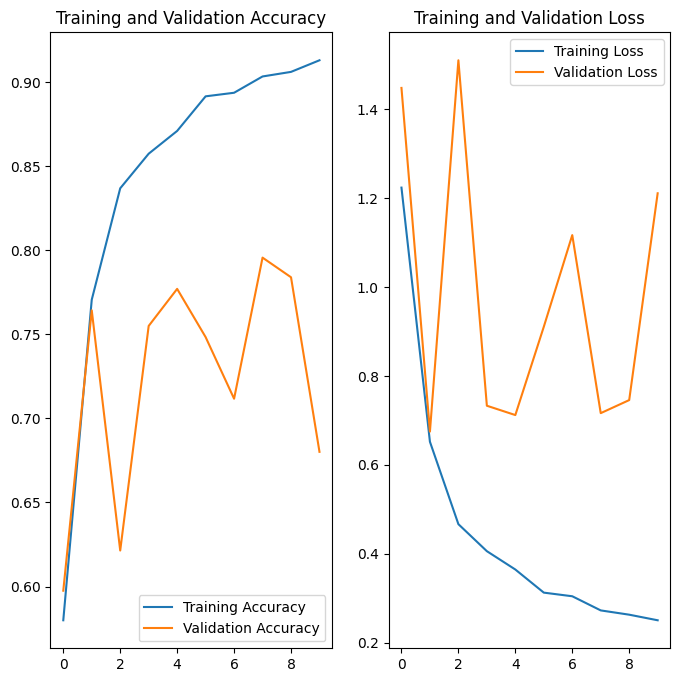

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.evaluate(val_ds)

118/118 [==============================] - 6s 55ms/step - loss: 1.2113 - accuracy: 0.6801


[1.211323618888855, 0.6801168322563171]

CLASSIFY NEW DATA

In [ ]:
leaf_path = pathlib.Path('yellowcurl2.png')

img = tf.keras.utils.load_img(
    leaf_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 130ms/step
This image most likely belongs to Tomato___Septoria_leaf_spot with a 85.46 percent confidence.
